# Computing photometry and SEDs of galaxies in a diffsky mock

This notebook shows how to compute photometry through arbitrary bands of galaxies in a diffsky mock stored in the `opencosmo` format, and how to compute high-res SEDs.

## Loading the mock data

The next two cells cells show how to load the mock files that are natively produced by the diffsky source code. For purposes of this demo, we will just work with a redshift slice, which will be downloaded in the next cell.

### Notes for beta testers: 
2. You must be using `opencosmo 1.0.4` and the [opencosmo-utils branch](https://github.com/ArgonneCPAC/diffsky/tree/opencosmo-utils) of `diffsky` for this notebook to work correctly.
1. This notebook will eventually use the cell below to download a small opencosmo-formatted mock catalog for testing/example purposes. For now, just ignore it. Instead, the notebook will be written as though you are working with one of synthetic catalogs on Perlmutter


In [1]:
! wget -P ./download_dir -q -r -e robots=off -np -nH --cut-dirs=7 --reject "index.html*" https://portal.nersc.gov/project/hacc/aphearin/diffsky_data/smdpl_dr1_12_03_2025

zsh:1: command not found: wget


In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [1]:
from diffsky.data_loaders.opencosmo_utils import load_diffsky_mock

directory = "/Users/patrick/Documents/Documents/temp/diffsky"

catalog, aux_data = load_diffsky_mock(directory)

### Inspect the mock data

The OpenCosmo toolkit provides extensive tooling for querying data, allowing you to select the specific types of objects you are interested in and prototype analyses on small samples before scaling them up. More details on the toolkit are available [in the documentation](https://opencosmo.readthedocs.io).

Additionally, the :code:`load_diffsky_mock` function returns auxilliary data which is used by diffsky to compute photometry or SEDs. The most important thing in this auxilliary data is the transmission curves, which determines which bands you can compute photometry for.

The full catalog contains millions of objects. We will select a much smaller subset for the purposes of this demo.

In [3]:
print("Transmission curves:", aux_data["tcurves"]._fields)
print(catalog)
# print(catalog.columns)

Transmission curves: ('lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y', 'roman_F062', 'roman_F087', 'roman_F106', 'roman_F129', 'roman_F158', 'roman_F184', 'roman_F146', 'roman_F213', 'roman_Prism', 'roman_Grism_1stOrder', 'roman_Grism_0thOrder')
OpenCosmo Lightcone Dataset (length=142131, 0.0 < z < 0.2422744128553771)
Cosmology: FlatLambdaCDM(name=None, H0=<Quantity 67.66 km / (Mpc s)>, Om0=0.3096446816186967, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=0.04897468161869667)
First 10 rows:
            delta_mag_ssp_scatter              ...         shear2        
                                               ...                       
                  float64[6]                   ...        float64        
---------------------------------------------- ... ----------------------
   0.07392284596703406 .. 0.049479374052803934 ... 1.0764403194687605e-05
  0.046118624440425596 .. 0.011164476337275046 ... 0.00031857139252707895
  0.008457047864665267 .. 0.012729843532124571

In [4]:
catalog = catalog.with_redshift_range(0.1, 0.2).take(10_000)
catalog

OpenCosmo Lightcone Dataset (length=10000, 0.1 < z < 0.2)
Cosmology: FlatLambdaCDM(name=None, H0=<Quantity 67.66 km / (Mpc s)>, Om0=0.3096446816186967, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=0.04897468161869667)
First 10 rows:
            delta_mag_ssp_scatter              ...         shear2        
                                               ...                       
                  float64[6]                   ...        float64        
---------------------------------------------- ... ----------------------
  -0.07400224380312412 .. -0.06558989290086814 ... -0.0001562938465925419
 -0.01740808444572416 .. 0.0032706884728090596 ...  0.0008581222788958048
   0.021408590285993134 .. 0.00853281151128011 ...  -0.002504313527412134
     0.13149318101804722 .. 0.0314695292207626 ... -0.0019273082922334824
   0.09450402497665461 .. -0.19327615226340608 ... -0.0013134634386850206
 -0.04043881914340945 .. -0.006863929649943766 ... -0.0009729371110750975
-0.06319833984711844 ..

### Recompute mock photometry

You can use the `compute_phot_from_diffsky_mock` function to compute mock photometry for any of the available bands. This function will compute photometry for the lsst_i and lsst_u bands, and insert them into the catalog as "lsst_i_new" and "lsst_u_new" (to avoid clashing with the exisiting lsst_i and lsst_u columns)


In [5]:
from diffsky.data_loaders.opencosmo_utils import compute_phot_from_diffsky_mock
catalog = compute_phot_from_diffsky_mock(catalog, aux_data, bands = ["lsst_u", "lsst_i"], insert = True)
photometry = catalog.select(("lsst_u", "lsst_i", "lsst_u_new", "lsst_i_new")).get_data("numpy")
assert np.allclose(photometry['lsst_u'], photometry['lsst_u_new'], atol=1e-2)
assert np.allclose(photometry['lsst_i'], photometry['lsst_i_new'], atol=1e-2)

AssertionError: 

### Recompute photometry of disk/bulge/knot decomposition

The photometry of each morphological component can be calculated using the `compute_dbk_phot_from_diffsky_mock` function.

In [6]:
from diffsky.data_loaders.opencosmo_utils import compute_dbk_phot_from_diffsky_mock
catalog = compute_dbk_phot_from_diffsky_mock(catalog, aux_data, bands = ["lsst_u", "lsst_i"], insert = True)
photometry = catalog.select(("lsst_u_bulge", "lsst_i_bulge", "lsst_u_bulge_new", "lsst_i_bulge_new")).get_data("numpy")

assert np.allclose(photometry['lsst_u_bulge'], photometry['lsst_u_bulge_new'], rtol=1e-2)
assert np.allclose(photometry['lsst_i_bulge'], photometry['lsst_i_bulge_new'], rtol=1e-2)

AssertionError: 

### Computing photometry in other bands

You can compute photometry in and band you like by simply providing new transmission curves

The next few cells show how to compute photometry through two fake bandpasses. We provide convinience functions for adding new transmission curves into the auxilliary data. This function expects tuples of (wavelength, tranmission_curve).

('lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y', 'roman_F062', 'roman_F087', 'roman_F106', 'roman_F129', 'roman_F158', 'roman_F184', 'roman_F146', 'roman_F213', 'roman_Prism', 'roman_Grism_1stOrder', 'roman_Grism_0thOrder', 'fake_band_1', 'fake_band_2')


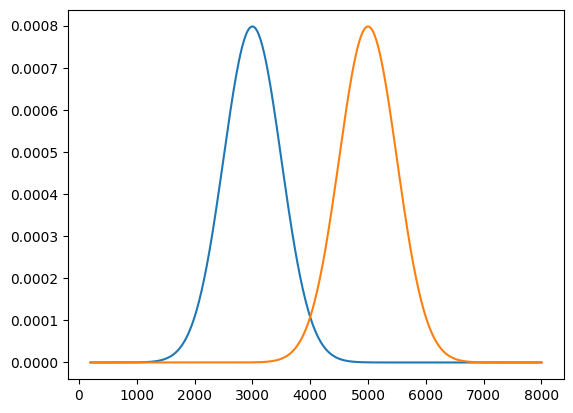

In [7]:
from jax.scipy.stats import norm as jnorm
from collections import namedtuple
from diffsky.data_loaders.opencosmo_utils import add_transmission_curves

wave = np.linspace(200, 8_000, 500)
fake_band_1 = jnorm.pdf(wave, loc=3_000.0, scale=500.0)
fake_band_2 = jnorm.pdf(wave, loc=5_000.0, scale=500.0)

# transmission curves will take their argument name
aux_data = add_transmission_curves(aux_data, fake_band_1 = (wave, fake_band_1), fake_band_2 = (wave, fake_band_2))

fig, ax = plt.subplots(1, 1)
__=ax.plot(wave, fake_band_1)
__=ax.plot(wave, fake_band_2)

# You should now see the new tranmission curves in the list of tranmission curves
print(aux_data["tcurves"]._fields)

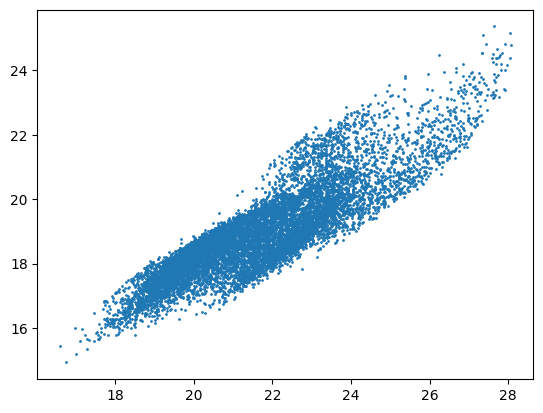

In [9]:
from diffsky.data_loaders.opencosmo_utils import compute_dbk_phot_from_diffsky_mock
catalog = compute_phot_from_diffsky_mock(catalog, aux_data, bands = ["fake_band_1", "fake_band_2"], insert = True)
fake_magnitudes = catalog.select(("fake_band_1", "fake_band_2")).get_data("numpy")

fig, ax = plt.subplots(1, 1)

__=ax.scatter(fake_magnitudes["fake_band_1"], fake_magnitudes["fake_band_2"], s=1)

### Compute SED of diffsky galaxies

There is also a convenience function for computing the high-resolution SED of each diffsky galaxy. Be aware this computation is memory-intensive, and it is recommended you only compute it for at most ~1000 galaxies at a time.

OpenCosmo can handle multi-dimension columns (such as an SED). However for the moment, we will set `insert = False` which  just directly returns the SED to us.

**Note for beta testers**: opencosmo 1.1 will include the ability to batch this computation over subsets of a very large dataset. For the moment, we will just select a smaller subset of this data for example purposes

In [10]:
from diffsky.data_loaders.opencosmo_utils import compute_seds_from_diffsky_mock 
sed_catalog = catalog.take(100)
seds = compute_seds_from_diffsky_mock(sed_catalog, aux_data, bands = ["lsst_u", "lsst_i"], insert=False)

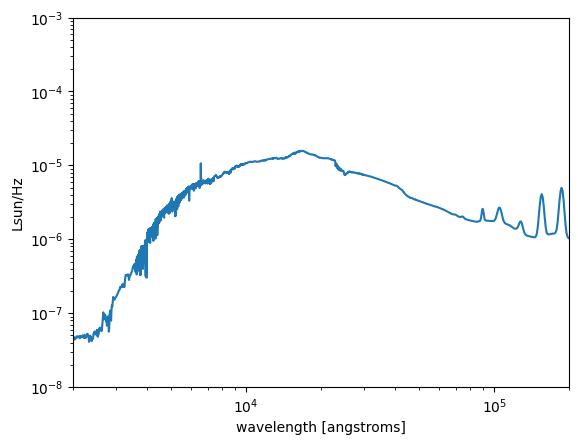

In [11]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
xlim = ax.set_xlim(2_000, 200_000)
ylim = ax.set_ylim(1e-8, 1e-3)

igal = 50
__=ax.plot(aux_data['ssp_data'].ssp_wave, seds["rest_sed"][igal, :])
xlabel = ax.set_xlabel('wavelength [angstroms]')
ylabel = ax.set_ylabel('Lsun/Hz')

### Compute SED of disk/bulge/knot components

There is an additional convenience function for computing the high-resolution SED of each morphological component.

## Note to beta testers: This tool is not currently working

In [4]:
from diffsky.data_loaders.opencosmo_utils import compute_dbk_seds_from_diffsky_mock 
dbk_sed_info = compute_dbk_seds_from_diffsky_mock(sed_catalog, aux_data, bands = ["lsst_u", "lsst_i"], insert=False)

ValueError: Incompatible shapes for broadcasting: (100,) and requested shape (700,)

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
xlim = ax.set_xlim(2_000, 200_000)
ylim = ax.set_ylim(1e-8, 1e-4)

igal = 50
__=ax.plot(diffsky_lc_patch['ssp_data'].ssp_wave, dbk_sed_info['rest_sed_bulge'][igal, :])
__=ax.plot(diffsky_lc_patch['ssp_data'].ssp_wave, dbk_sed_info['rest_sed_disk'][igal, :])
__=ax.plot(diffsky_lc_patch['ssp_data'].ssp_wave, dbk_sed_info['rest_sed_knots'][igal, :])
xlabel = ax.set_xlabel('wavelength [angstroms]')
ylabel = ax.set_ylabel('Lsun/Hz')